In [3]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

import stg_energy.fig3_amortize_energy.viz as viz
from pyloric import create_prior, get_time, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import col, get_labels_8pt, svg
from stg_energy.fig3_amortize_energy.helper_functions import (
    active_subspace,
    get_gradient,
)

# Figure 3: additional nets
Here, we train 3 nets to predict the energy in AB/PD, LP, and PY. This will be used in fig5_cc

In [4]:
%load_ext autoreload
%autoreload 2

In [32]:
PANEL_quality_of_approx_LinReg = "../svg/panel_quality_of_approx_LinReg.svg"
PANEL_REG_D1_lin = "../svg/panel_reg_d1_lin.svg"
PANEL_REG_D2_lin = "../svg/panel_reg_d2_lin.svg"
PANEL_REG_D3_lin = "../svg/panel_reg_d3_lin.svg"
PANEL_REG_D4_lin = "../svg/panel_reg_d4_lin.svg"
PANEL_quality_of_approx_NN = "../svg/panel_quality_of_approx_NN.svg"
PANEL_lin_reg = "../svg/panel_lin_reg.svg"

### Load experimental data

In [6]:
prior_11 = create_prior(log=True)
dimensions_11 = 31
lims_11 = np.asarray(
    [-np.sqrt(3) * np.ones(dimensions_11), np.sqrt(3) * np.ones(dimensions_11)]
).T

params_mean_11 = prior_11.mean.numpy()
params_std_11 = prior_11.stddev.numpy()

In [7]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
good_stats = data["sample_stats"]
good_params = data["sample_params"]
good_seeds = data["sample_seeds"]

In [8]:
sample_params = good_params
sample_stats = good_stats
print("There are", len(good_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


In [9]:
sample_stats = data["sample_stats"]
sample_params = data["sample_params"]
sample_seeds = data["sample_seeds"]

In [10]:
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)

# Panel 0: Fit regression net

In [11]:
energies = torch.as_tensor(energies)
sample_stats = torch.as_tensor(sample_stats)

In [12]:
print(energies.shape)

torch.Size([55043, 3])


In [13]:
num_test = 500

test_params = good_params[:num_test]
train_params = good_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

### AB/PD

In [14]:
train_energy_ABPD = torch.sum(energies[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(energies[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
regressor = LinearRegression()

In [17]:
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)

In [18]:
predictions = fitted_reg.predict(test_params_norm)

In [19]:
mean_energy

tensor(3780229.3953, dtype=torch.float64)

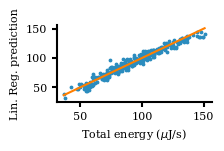

In [56]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x.numpy()/40000, y=unnorm_y/40000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy())/40000, np.max(unnorm_x.numpy())/40000, 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Lin. Reg. prediction")
    plt.savefig(PANEL_quality_of_approx_LinReg, facecolor='None', transparent=False)

In [21]:
coeff = np.asarray([fitted_reg.coef_[0]])

In [22]:
coeff

array([[ 0.24386115,  0.24714988,  0.22915705, -0.20228311,  0.02741928,
        -0.0867205 , -0.01520331, -0.02410771,  0.06194275,  0.1165701 ,
         0.25380537, -0.12808335,  0.00068791, -0.0904568 ,  0.01791403,
        -0.03450488,  0.4474904 ,  0.55777943,  0.31478217, -0.24465199,
        -0.14649534, -0.11644471,  0.01737932, -0.08561385,  0.04036997,
        -0.01357779, -0.02205842,  0.0396339 ,  0.01102217, -0.02230285,
         0.09144662]], dtype=float32)

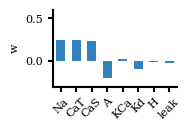

In [69]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 0:8], ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='w', plot_labels=True, color="#3182bd")
    plt.savefig(PANEL_REG_D1_lin, facecolor='None', transparent=False)

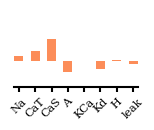

In [71]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 8:16], ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='', plot_labels=False, color="#fc8d59")
    plt.savefig(PANEL_REG_D2_lin, facecolor='None', transparent=False)

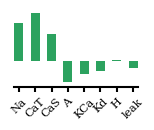

In [73]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(coeff[:1, 16:24], ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='', plot_labels=False, color="#2ca25f")
    plt.savefig(PANEL_REG_D3_lin, facecolor='None', transparent=False)

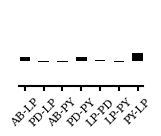

In [93]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(coeff[:1, 24:], ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='', color="k")
    plt.savefig(PANEL_REG_D4_lin, facecolor='None', transparent=False)

In [75]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [96]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "7.2cm",
           
    Panel(
          SVG(PANEL_lin_reg).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -2*factor_svg, -0.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 3.0*factor_svg),
    
    Panel(
          SVG(PANEL_quality_of_approx_LinReg).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -2*factor_svg, 1.2*factor_svg, **kwargs_text),
    ).move(36.1*factor_svg, 1.3*factor_svg),
           
    Panel(
          SVG(PANEL_quality_of_approx_NN).scale(svg_scale).move(0, 0*factor_svg),
    ).move(73*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D1_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("c", -2*factor_svg, -1.0*factor_svg, **kwargs_text),
        Text("AB/PD", 16.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, 28*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D2_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("LP", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(33*factor_svg, 28*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D3_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("PY", 11.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(58*factor_svg, 28*factor_svg),
    
    Panel(
          SVG(PANEL_REG_D4_lin).scale(svg_scale).move(0, 0*factor_svg),
        Text("Synapses", 8.0*factor_svg, 3.5*factor_svg, **kwargs_text8pt),
    ).move(83*factor_svg, 28*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig3_reg_supp_linear_reg.svg")
svg('../fig/fig3_reg_supp_linear_reg.svg')